## Imports

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
from statsmodels.stats.contingency_tables import mcnemar

## Dataset

In [4]:
df = pd.read_csv("../data/merged/all_models_merged.csv")

## Functions

In [5]:
def create_mcnemar_table(eng_correct, fil_correct):
    """
    Create 2x2 contingency table for McNemar's test
    
    Parameters:
    eng_correct: Series/array of boolean values indicating English correctness
    fil_correct: Series/array of boolean values indicating Filipino correctness
    
    Returns:
    numpy array: 2x2 contingency table
    
    Table structure:
                Filipino
                 0    1
    English  0  a    b
             1  c    d
    
    Where:
    a = both wrong
    b = English wrong, Filipino correct  
    c = English correct, Filipino wrong
    d = both correct
    """
    
    # Convert boolean to int for easier counting
    eng = eng_correct.astype(int)
    fil = fil_correct.astype(int)
    
    # Count each combination
    both_wrong = ((eng == 0) & (fil == 0)).sum()          # a
    eng_wrong_fil_right = ((eng == 0) & (fil == 1)).sum() # b
    eng_right_fil_wrong = ((eng == 1) & (fil == 0)).sum() # c
    both_right = ((eng == 1) & (fil == 1)).sum()          # d
    
    # Create contingency table
    table = np.array([[both_wrong, eng_wrong_fil_right],
                     [eng_right_fil_wrong, both_right]])
    
    return table

In [6]:
def print_contingency_table(table, title="Contingency Table"):
    """
    Pretty print a McNemar contingency table
    
    Parameters:
    table: 2x2 numpy array
    title: string title for the table
    """
    print(f"{title}:")
    print("                Filipino")
    print("                0     1")
    print(f"English    0   {table[0,0]:4d}  {table[0,1]:4d}")
    print(f"           1   {table[1,0]:4d}  {table[1,1]:4d}")

In [7]:
# Cohen's g helpers for McNemar (paired binary)
# g = (c - b) / n where b=Eng wrong & Fil correct, c=Eng correct & Fil wrong, n=total
# Positive g => English advantage; Negative g => Filipino advantage

def cohens_g_from_table(table):
    b = table[0, 1]
    c = table[1, 0]
    n = table.sum()
    return ((c - b) / n) if n > 0 else np.nan, b, c, n

def interpret_g(g):
    if np.isnan(g):
        return "N/A"
    ag = abs(g)
    if ag < 0.05:
        return "Trivial"
    if ag < 0.15:
        return "Small"
    if ag < 0.25:
        return "Medium"
    return "Large"

## Overall

In [8]:
# Create table for all data
overall_table = create_mcnemar_table(df['is_correct_eng'], df['is_correct_fil'])
print_contingency_table(overall_table, "Overall McNemar Table")

# Run McNemar's test
result = mcnemar(overall_table, exact=False, correction=True)

print(f"\nMcNemar's Test Results:")
print(f"Test Statistic: {result.statistic:.4f}")
print(f"P-value: {result.pvalue:.6f}")
print(f"Significance Level: α = 0.05")
print(f"Result: {'Statistically significant difference' if result.pvalue < 0.05 else 'No statistically significant difference'}")

# Interpret directly from contingency table
b = overall_table[0, 1]  # English wrong, Filipino correct
c = overall_table[1, 0]  # English correct, Filipino wrong

print(f"\nDirect Interpretation:")
print(f"English correct, Filipino wrong: {c}")
print(f"English wrong, Filipino correct: {b}")

if c > b:
    print(f"English performs better (English correct {c} times when Filipino wrong vs {b} times opposite)")
elif b > c:
    print(f"Filipino performs better (Filipino correct {b} times when English wrong vs {c} times opposite)")
else:
    print(f"Equal performance (both have {c} discordant pairs)")

print(f"Difference: {c - b} (positive = English advantage)")

# Cohen's g for overall
overall_g, ob, oc, on = cohens_g_from_table(overall_table)
print(f"Cohen's g: {overall_g:.3f} ({interpret_g(overall_g)}) | b={ob}, c={oc}, n={on}")

Overall McNemar Table:
                Filipino
                0     1
English    0    222    70
           1    670  4568

McNemar's Test Results:
Test Statistic: 484.8662
P-value: 0.000000
Significance Level: α = 0.05
Result: Statistically significant difference

Direct Interpretation:
English correct, Filipino wrong: 670
English wrong, Filipino correct: 70
English performs better (English correct 670 times when Filipino wrong vs 70 times opposite)
Difference: 600 (positive = English advantage)
Cohen's g: 0.108 (Small) | b=70, c=670, n=5530


## Model

In [9]:
# McNemar's test by model
print("McNemar's Test by Model")
print("=" * 50)

for model in df['model'].unique():
    model_data = df[df['model'] == model]

    print(f"\nModel: {model}")
    print("-" * 30)

    # Create table for this model
    model_table = create_mcnemar_table(model_data['is_correct_eng'], model_data['is_correct_fil'])
    print_contingency_table(model_table, f"{model} McNemar Table")

    # Run McNemar's test
    result = mcnemar(model_table, exact=False, correction=True)

    print(f"\nMcNemar's Test Results:")
    print(f"Test Statistic: {result.statistic:.4f}")
    print(f"P-value: {result.pvalue:.6f}")
    print(f"Significance Level: α = 0.05")
    print(f"Result: {'Statistically significant difference' if result.pvalue < 0.05 else 'No statistically significant difference'}")

    # Interpret directly from contingency table
    b = model_table[0, 1]  # English wrong, Filipino correct
    c = model_table[1, 0]  # English correct, Filipino wrong

    print(f"\nDirect Interpretation:")
    print(f"English correct, Filipino wrong: {c}")
    print(f"English wrong, Filipino correct: {b}")

    if c > b:
        print(f"English performs better (English correct {c} times when Filipino wrong vs {b} times opposite)")
    elif b > c:
        print(f"Filipino performs better (Filipino correct {b} times when English wrong vs {c} times opposite)")
    else:
        print(f"Equal performance (both have {c} discordant pairs)")

    print(f"Difference: {c - b} (positive = English advantage)")

    # Cohen's g for this model
    g, tb, tc, tn = cohens_g_from_table(model_table)
    print(f"Cohen's g: {g:.3f} ({interpret_g(g)}) | b={tb}, c={tc}, n={tn}")

    print("\n" + "="*50)

McNemar's Test by Model

Model: deepseek-reasoner
------------------------------
deepseek-reasoner McNemar Table:
                Filipino
                0     1
English    0     23     8
           1     94   665

McNemar's Test Results:
Test Statistic: 70.8333
P-value: 0.000000
Significance Level: α = 0.05
Result: Statistically significant difference

Direct Interpretation:
English correct, Filipino wrong: 94
English wrong, Filipino correct: 8
English performs better (English correct 94 times when Filipino wrong vs 8 times opposite)
Difference: 86 (positive = English advantage)
Cohen's g: 0.109 (Small) | b=8, c=94, n=790


Model: deepseek-chat
------------------------------
deepseek-chat McNemar Table:
                Filipino
                0     1
English    0     98    23
           1    240   429

McNemar's Test Results:
Test Statistic: 177.3992
P-value: 0.000000
Significance Level: α = 0.05
Result: Statistically significant difference

Direct Interpretation:
English correct, F

## Type

In [10]:
# McNemar's test by question type
print("McNemar's Test by Question Type")
print("=" * 50)

for question_type in df['type'].unique():
    type_data = df[df['type'] == question_type]
    
    print(f"\nType: {question_type}")
    print("-" * 30)
    
    # Create table for this type
    type_table = create_mcnemar_table(type_data['is_correct_eng'], type_data['is_correct_fil'])
    print_contingency_table(type_table, f"{question_type} McNemar Table")
    
    # Run McNemar's test
    result = mcnemar(type_table, exact=False, correction=True)
    
    print(f"\nMcNemar's Test Results:")
    print(f"Test Statistic: {result.statistic:.4f}")
    print(f"P-value: {result.pvalue:.6f}")
    print(f"Significance Level: α = 0.05")
    print(f"Result: {'Statistically significant difference' if result.pvalue < 0.05 else 'No statistically significant difference'}")
    
    # Interpret directly from contingency table
    b = type_table[0, 1]  # English wrong, Filipino correct
    c = type_table[1, 0]  # English correct, Filipino wrong
    
    print(f"\nDirect Interpretation:")
    print(f"English correct, Filipino wrong: {c}")
    print(f"English wrong, Filipino correct: {b}")
    
    if c > b:
        print(f"English performs better (English correct {c} times when Filipino wrong vs {b} times opposite)")
    elif b > c:
        print(f"Filipino performs better (Filipino correct {b} times when English wrong vs {c} times opposite)")
    else:
        print(f"Equal performance (both have {c} discordant pairs)")
    
    print(f"Difference: {c - b} (positive = English advantage)")

    # Cohen's g for this type
    g, tb, tc, tn = cohens_g_from_table(type_table)
    print(f"Cohen's g: {g:.3f} ({interpret_g(g)}) | b={tb}, c={tc}, n={tn}")

    print("\n" + "="*50)

McNemar's Test by Question Type

Type: Adversarial
------------------------------
Adversarial McNemar Table:
                Filipino
                0     1
English    0    140    43
           1    416  2376

McNemar's Test Results:
Test Statistic: 301.4902
P-value: 0.000000
Significance Level: α = 0.05
Result: Statistically significant difference

Direct Interpretation:
English correct, Filipino wrong: 416
English wrong, Filipino correct: 43
English performs better (English correct 416 times when Filipino wrong vs 43 times opposite)
Difference: 373 (positive = English advantage)
Cohen's g: 0.125 (Small) | b=43, c=416, n=2975


Type: Non-Adversarial
------------------------------
Non-Adversarial McNemar Table:
                Filipino
                0     1
English    0     82    27
           1    254  2192

McNemar's Test Results:
Test Statistic: 181.7651
P-value: 0.000000
Significance Level: α = 0.05
Result: Statistically significant difference

Direct Interpretation:
English cor

## Category

In [11]:
# McNemar's test by category
print("McNemar's Test by Category")
print("=" * 50)

for category in df['category'].unique():
    category_data = df[df['category'] == category]
    
    print(f"\nCategory: {category}")
    print("-" * 30)
    
    # Create table for this category
    category_table = create_mcnemar_table(category_data['is_correct_eng'], category_data['is_correct_fil'])
    print_contingency_table(category_table, f"{category} McNemar Table")
    
    # Run McNemar's test
    result = mcnemar(category_table, exact=False, correction=True)
    
    print(f"\nMcNemar's Test Results:")
    print(f"Test Statistic: {result.statistic:.4f}")
    print(f"P-value: {result.pvalue:.6f}")
    print(f"Significance Level: α = 0.05")
    print(f"Result: {'Statistically significant difference' if result.pvalue < 0.05 else 'No statistically significant difference'}")
    
    # Interpret directly from contingency table
    b = category_table[0, 1]  # English wrong, Filipino correct
    c = category_table[1, 0]  # English correct, Filipino wrong
    
    print(f"\nDirect Interpretation:")
    print(f"English correct, Filipino wrong: {c}")
    print(f"English wrong, Filipino correct: {b}")
    
    if c > b:
        print(f"English performs better (English correct {c} times when Filipino wrong vs {b} times opposite)")
    elif b > c:
        print(f"Filipino performs better (Filipino correct {b} times when English wrong vs {c} times opposite)")
        
    else:
        print(f"Equal performance (both have {c} discordant pairs)")
    
    print(f"Difference: {c - b} (positive = English advantage)")

    # Cohen's g for this category
    g, cb, cc, cn = cohens_g_from_table(category_table)
    print(f"Cohen's g: {g:.3f} ({interpret_g(g)}) | b={cb}, c={cc}, n={cn}")

    print("\n" + "="*50)

McNemar's Test by Category

Category: Misconceptions
------------------------------
Misconceptions McNemar Table:
                Filipino
                0     1
English    0     12     5
           1     54   629

McNemar's Test Results:
Test Statistic: 39.0508
P-value: 0.000000
Significance Level: α = 0.05
Result: Statistically significant difference

Direct Interpretation:
English correct, Filipino wrong: 54
English wrong, Filipino correct: 5
English performs better (English correct 54 times when Filipino wrong vs 5 times opposite)
Difference: 49 (positive = English advantage)
Cohen's g: 0.070 (Small) | b=5, c=54, n=700


Category: Proverbs
------------------------------
Proverbs McNemar Table:
                Filipino
                0     1
English    0      6     4
           1     29    87

McNemar's Test Results:
Test Statistic: 17.4545
P-value: 0.000029
Significance Level: α = 0.05
Result: Statistically significant difference

Direct Interpretation:
English correct, Filipino 

## Topic

In [12]:
# McNemar's test by topic
print("McNemar's Test by Topic")
print("=" * 50)

# Skip placeholder topics
skip_topics = {'-1_years_happens_school_does'}
topics = [t for t in df['topic'].dropna().unique() if t not in skip_topics]

for topic in topics:
    topic_data = df[df['topic'] == topic]
    
    print(f"\nTopic: {topic}")
    print("-" * 30)
    
    # Create table for this topic
    topic_table = create_mcnemar_table(topic_data['is_correct_eng'], topic_data['is_correct_fil'])
    print_contingency_table(topic_table, f"{topic} McNemar Table")
    
    # Run McNemar's test
    result = mcnemar(topic_table, exact=False, correction=True)
    
    print(f"\nMcNemar's Test Results:")
    print(f"Test Statistic: {result.statistic:.4f}")
    print(f"P-value: {result.pvalue:.6f}")
    print(f"Significance Level: α = 0.05")
    print(f"Result: {'Statistically significant difference' if result.pvalue < 0.05 else 'No statistically significant difference'}")
    
    # Interpret directly from contingency table
    b = topic_table[0, 1]  # English wrong, Filipino correct
    c = topic_table[1, 0]  # English correct, Filipino wrong
    
    print(f"\nDirect Interpretation:")
    print(f"English correct, Filipino wrong: {c}")
    print(f"English wrong, Filipino correct: {b}")
    
    if c > b:
        print(f"English performs better (English correct {c} times when Filipino wrong vs {b} times opposite)")
    elif b > c:
        print(f"Filipino performs better (Filipino correct {b} times when English wrong vs {c} times opposite)")
    else:
        print(f"Equal performance (both have {c} discordant pairs)")
    
    print(f"Difference: {c - b} (positive = English advantage)")

    # Cohen's g for this topic
    g, tb, tc, tn = cohens_g_from_table(topic_table)
    print(f"Cohen's g: {g:.3f} ({interpret_g(g)}) | b={tb}, c={tc}, n={tn}")

    print("\n" + "="*50)

McNemar's Test by Topic

Topic: 0_did_said_say_moon
------------------------------
0_did_said_say_moon McNemar Table:
                Filipino
                0     1
English    0     25    11
           1     64   544

McNemar's Test Results:
Test Statistic: 36.0533
P-value: 0.000000
Significance Level: α = 0.05
Result: Statistically significant difference

Direct Interpretation:
English correct, Filipino wrong: 64
English wrong, Filipino correct: 11
English performs better (English correct 64 times when Filipino wrong vs 11 times opposite)
Difference: 53 (positive = English advantage)
Cohen's g: 0.082 (Small) | b=11, c=64, n=644


Topic: 6_swallow_cardiac_going_prevent
------------------------------
6_swallow_cardiac_going_prevent McNemar Table:
                Filipino
                0     1
English    0      2     3
           1     14   184

McNemar's Test Results:
Test Statistic: 5.8824
P-value: 0.015293
Significance Level: α = 0.05
Result: Statistically significant difference



In [13]:
# Summary of McNemar's Test Results with Cohen's g
print("SUMMARY OF McNEMAR'S TEST RESULTS")
print("=" * 80)

# Helper for formatting p-values
def format_p(p):
    try:
        return "<1e-6" if p < 1e-6 else f"{p:.6f}"
    except Exception:
        return str(p)

# Overall summary
overall_table = create_mcnemar_table(df['is_correct_eng'], df['is_correct_fil'])
overall_result = mcnemar(overall_table, exact=False, correction=True)
overall_g, overall_b, overall_c, overall_n = cohens_g_from_table(overall_table)

better_lang_overall = (
    "English" if overall_g > 0 else "Filipino" if overall_g < 0 else "Equal"
)

print(f"\nOVERALL PERFORMANCE:")
print(f"P-value: {format_p(overall_result.pvalue)}")
print(f"Significant: {'Yes' if overall_result.pvalue < 0.05 else 'No'}")
print(f"Better Language: {better_lang_overall}")
print(f"Cohen's g: {overall_g:.3f} ({interpret_g(overall_g)})")
print(f"Discordant: b={overall_b}, c={overall_c} (b+c={overall_b + overall_c}), n={overall_n}")

# Formatting helpers
header_common = f"{'P-value':>10} {'Significant':<12} {'Better Language':<15} {'g':>8} {'Magnitude':<10}"
sep_len = 45 + 10 + 12 + 15 + 8 + 10 + 5  # columns + spaces ~ 105

# Model summary (sorted by |g| desc)
print(f"\nBY MODEL (sorted by |g|):")
print(f"{'Model':<45} {header_common}")
print("-" * sep_len)

model_rows = []
for model in df['model'].unique():
    model_data = df[df['model'] == model]
    model_table = create_mcnemar_table(model_data['is_correct_eng'], model_data['is_correct_fil'])
    model_result = mcnemar(model_table, exact=False, correction=True)
    g, b, c, n = cohens_g_from_table(model_table)

    model_rows.append({
        'label': model,
        'p': float(model_result.pvalue),
        'sig': 'Yes' if model_result.pvalue < 0.05 else 'No',
        'better': 'English' if g > 0 else 'Filipino' if g < 0 else 'Equal',
        'g': float(g),
        'mag': interpret_g(g)
    })

model_rows.sort(key=lambda r: abs(r['g']) if not np.isnan(r['g']) else -np.inf, reverse=True)
for r in model_rows:
    p_str = format_p(r['p'])
    print(f"{r['label']:<45} {p_str:>10} {r['sig']:<12} {r['better']:<15} {r['g']:>8.3f} {r['mag']:<10}")

# Type summary (sorted by |g| desc)
print(f"\nBY QUESTION TYPE (sorted by |g|):")
print(f"{'Type':<45} {header_common}")
print("-" * sep_len)

type_rows = []
for question_type in df['type'].unique():
    type_data = df[df['type'] == question_type]
    type_table = create_mcnemar_table(type_data['is_correct_eng'], type_data['is_correct_fil'])
    type_result = mcnemar(type_table, exact=False, correction=True)
    g, b, c, n = cohens_g_from_table(type_table)

    type_rows.append({
        'label': question_type,
        'p': float(type_result.pvalue),
        'sig': 'Yes' if type_result.pvalue < 0.05 else 'No',
        'better': 'English' if g > 0 else 'Filipino' if g < 0 else 'Equal',
        'g': float(g),
        'mag': interpret_g(g)
    })

type_rows.sort(key=lambda r: abs(r['g']) if not np.isnan(r['g']) else -np.inf, reverse=True)
for r in type_rows:
    p_str = format_p(r['p'])
    print(f"{r['label']:<45} {p_str:>10} {r['sig']:<12} {r['better']:<15} {r['g']:>8.3f} {r['mag']:<10}")

# Category summary (sorted by |g| desc)
print(f"\nBY CATEGORY (sorted by |g|):")
print(f"{'Category':<45} {header_common}")
print("-" * sep_len)

category_rows = []
for category in df['category'].unique():
    category_data = df[df['category'] == category]
    category_table = create_mcnemar_table(category_data['is_correct_eng'], category_data['is_correct_fil'])
    category_result = mcnemar(category_table, exact=False, correction=True)
    g, b, c, n = cohens_g_from_table(category_table)

    category_rows.append({
        'label': category,
        'p': float(category_result.pvalue),
        'sig': 'Yes' if category_result.pvalue < 0.05 else 'No',
        'better': 'English' if g > 0 else 'Filipino' if g < 0 else 'Equal',
        'g': float(g),
        'mag': interpret_g(g)
    })

category_rows.sort(key=lambda r: abs(r['g']) if not np.isnan(r['g']) else -np.inf, reverse=True)
for r in category_rows:
    p_str = format_p(r['p'])
    print(f"{r['label']:<45} {p_str:>10} {r['sig']:<12} {r['better']:<15} {r['g']:>8.3f} {r['mag']:<10}")

# Topic summary (sorted by |g| desc)
print(f"\nBY TOPIC (sorted by |g|):")
print(f"{'Topic':<45} {header_common}")
print("-" * sep_len)

skip_topics = {'-1_years_happens_school_does'}
topics = [t for t in df['topic'].dropna().unique() if t not in skip_topics]

topic_rows = []
for topic in topics:
    topic_data = df[df['topic'] == topic]
    topic_table = create_mcnemar_table(topic_data['is_correct_eng'], topic_data['is_correct_fil'])
    topic_result = mcnemar(topic_table, exact=False, correction=True)
    g, b, c, n = cohens_g_from_table(topic_table)

    topic_rows.append({
        'label': topic,
        'p': float(topic_result.pvalue),
        'sig': 'Yes' if topic_result.pvalue < 0.05 else 'No',
        'better': 'English' if g > 0 else 'Filipino' if g < 0 else 'Equal',
        'g': float(g),
        'mag': interpret_g(g)
    })

topic_rows.sort(key=lambda r: abs(r['g']) if not np.isnan(r['g']) else -np.inf, reverse=True)
for r in topic_rows:
    p_str = format_p(r['p'])
    print(f"{r['label']:<45} {p_str:>10} {r['sig']:<12} {r['better']:<15} {r['g']:>8.3f} {r['mag']:<10}")

# Count significant results
model_significant_count = sum(1 for r in model_rows if r['sig'] == 'Yes')
type_significant_count = sum(1 for r in type_rows if r['sig'] == 'Yes')
category_significant_count = sum(1 for r in category_rows if r['sig'] == 'Yes')
topic_significant_count = sum(1 for r in topic_rows if r['sig'] == 'Yes')

print(f"\nSUMMARY STATISTICS:")
print(f"Significant differences by model: {model_significant_count}/{len(df['model'].unique())}")
print(f"Significant differences by type: {type_significant_count}/{len(df['type'].unique())}")
print(f"Significant differences by category: {category_significant_count}/{len(df['category'].unique())}")
print(f"Significant differences by topic: {topic_significant_count}/{len(topics)}")

SUMMARY OF McNEMAR'S TEST RESULTS



OVERALL PERFORMANCE:
P-value: <1e-6
Significant: Yes
Better Language: English
Cohen's g: 0.108 (Small)
Discordant: b=70, c=670 (b+c=740), n=5530

BY MODEL (sorted by |g|):
Model                                            P-value Significant  Better Language        g Magnitude 
---------------------------------------------------------------------------------------------------------
deepseek-chat                                      <1e-6 Yes          English            0.275 Large     
gemini-2.5-flash                                   <1e-6 Yes          English            0.262 Large     
deepseek-reasoner                                  <1e-6 Yes          English            0.109 Small     
claude-sonnet-4-20250514                           <1e-6 Yes          English            0.076 Small     
gemini-2.5-pro                                  0.000126 Yes          English            0.028 Trivial   
gpt-5-mini-2025-08-07                           0.256145 No           English       

## Visualizations

Cohen's g Magnitude Counts by Grouping:
   Grouping  Trivial  Small  Medium  Large  N/A  Total
0     Model        3      2       0      2    0      7
1      Type        0      2       0      0    0      2
2  Category        3     24       9      1    0     37
3     Topic        1     14       3      1    0     19

Percentages by Grouping:
   Grouping  Trivial %  Small %  Medium %  Large %  N/A %  Total
0     Model       42.9     28.6       0.0     28.6    0.0      7
1      Type        0.0    100.0       0.0      0.0    0.0      2
2  Category        8.1     64.9      24.3      2.7    0.0     37
3     Topic        5.3     73.7      15.8      5.3    0.0     19

Average absolute Cohen's g by Grouping:
   Grouping   Avg |g|  Median |g|   k
0     Model  0.108499    0.075949   7
1      Type  0.107112    0.107112   2
2  Category  0.120532    0.104396  37
3     Topic  0.118661    0.099379  19


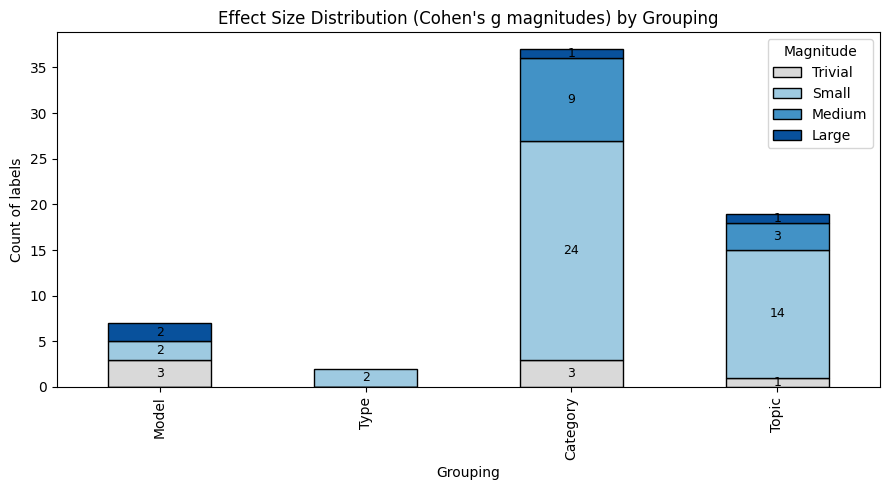

{'counts':    Grouping  Trivial  Small  Medium  Large  N/A  Total
 0     Model        3      2       0      2    0      7
 1      Type        0      2       0      0    0      2
 2  Category        3     24       9      1    0     37
 3     Topic        1     14       3      1    0     19,
 'percentages':    Grouping  Trivial  Small  Medium  Large  N/A  Total  Trivial %  Small %  \
 0     Model        3      2       0      2    0      7       42.9     28.6   
 1      Type        0      2       0      0    0      2        0.0    100.0   
 2  Category        3     24       9      1    0     37        8.1     64.9   
 3     Topic        1     14       3      1    0     19        5.3     73.7   
 
    Medium %  Large %  N/A %  
 0       0.0     28.6    0.0  
 1       0.0      0.0    0.0  
 2      24.3      2.7    0.0  
 3      15.8      5.3    0.0  ,
 'avg_abs_g':    Grouping   Avg |g|  Median |g|   k
 0     Model  0.108499    0.075949   7
 1      Type  0.107112    0.107112   2
 2  Categor

In [14]:
# Effect Sizes: Distribution of Cohen's g magnitudes by grouping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PLACEHOLDER_TOPIC = '-1_years_happens_school_does'

# Build effect size records (g and Magnitude) per label within a grouping
def effect_size_records(df: pd.DataFrame, group_col: str, skip_values=None):
    if skip_values is None:
        skip_values = set()
    rows = []
    labels = [g for g in df[group_col].dropna().unique() if g not in skip_values]
    for lab in labels:
        subset = df[df[group_col] == lab]
        if subset.empty:
            continue
        tbl = create_mcnemar_table(subset['is_correct_eng'], subset['is_correct_fil'])
        g, b, c, n = cohens_g_from_table(tbl)
        mag = interpret_g(g)
        rows.append({
            'Label': lab,
            'g': float(g) if not pd.isna(g) else np.nan,
            'Magnitude': mag,
            'b': int(b), 'c': int(c), 'n': int(n)
        })
    return pd.DataFrame(rows)

mags_order = ['Trivial', 'Small', 'Medium', 'Large', 'N/A']

distribution_records = []
avg_absg_records = []
raw_tables = {}

for col, name, skip in [
    ('model', 'Model', set()),
    ('type', 'Type', set()),
    ('category', 'Category', set()),
    ('topic', 'Topic', {PLACEHOLDER_TOPIC}),  # skip placeholder topic
]:
    eff_df = effect_size_records(df, col, skip)
    raw_tables[name] = eff_df
    # Counts of magnitudes
    counts = eff_df['Magnitude'].value_counts().reindex(mags_order, fill_value=0)
    distribution_records.append({'Grouping': name, **counts.to_dict(), 'Total': int(len(eff_df))})
    # Average |g|
    avg_abs_g = float(eff_df['g'].abs().mean()) if not eff_df.empty else np.nan
    med_abs_g = float(eff_df['g'].abs().median()) if not eff_df.empty else np.nan
    avg_absg_records.append({'Grouping': name, 'Avg |g|': avg_abs_g, 'Median |g|': med_abs_g, 'k': int(len(eff_df))})

# Counts table
dist_df = pd.DataFrame(distribution_records)
print("Cohen's g Magnitude Counts by Grouping:")
print(dist_df[['Grouping'] + mags_order + ['Total']])

# Percentages table
pct_df = dist_df.copy()
with np.errstate(invalid='ignore', divide='ignore'):
    for mag in mags_order:
        pct_df[f'{mag} %'] = (pct_df[mag] / pct_df['Total'] * 100).round(1)
print("\nPercentages by Grouping:")
print(pct_df[['Grouping'] + [f'{m} %' for m in mags_order] + ['Total']])

# Average |g| table
avg_df = pd.DataFrame(avg_absg_records)
print("\nAverage absolute Cohen's g by Grouping:")
print(avg_df[['Grouping', 'Avg |g|', 'Median |g|', 'k']])

# Plot stacked bar of magnitudes (exclude 'N/A' from bars by default but keep in tables)
plot_mags = ['Trivial', 'Small', 'Medium', 'Large']
plot_df = dist_df.set_index('Grouping')[plot_mags]
colors = {
    'Trivial': '#d9d9d9',
    'Small': '#9ecae1',
    'Medium': '#4292c6',
    'Large': '#08519c',
}
ax = plot_df.plot(kind='bar', stacked=True, figsize=(9, 5), color=[colors[m] for m in plot_mags], edgecolor='black')
ax.set_title("Effect Size Distribution (Cohen's g magnitudes) by Grouping")
ax.set_xlabel('Grouping')
ax.set_ylabel('Count of labels')
ax.legend(title='Magnitude', loc='upper right')

# Annotate counts
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + height / 2
        ax.annotate(f"{int(height)}", (x, y), ha='center', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Return raw per-label tables for optional downstream use
{'counts': dist_df, 'percentages': pct_df, 'avg_abs_g': avg_df, 'details': raw_tables}